# Extracting functional brain atlas:

Before analyzing functional connectivity, we need to reduce the dimensionality of the problem. To do that, we estimate an atlas directly on our data.

In this tutorial we will learn:
    * Downloading the ABIDE dataset and computing brain masks
    * Using Canonical ICA to create a brain atlas
    * Generating ROIs from the atlas
    * Building a connectome

In [13]:
# This line allows plotting directly in the notebook
%matplotlib inline

# Python scientific package
import numpy as np
import nilearn

# Loading the data

Nilearn provides a bunch of automatic downloaders to ease reproducibility of the analysis. With nilearn, an analysis is run in a single script and can be shared easily.
The nilearn fetchers can be found in the module nilearn.datasets.

In [14]:
from nilearn.datasets import fetch_abide_pcp


# We specify the site and number of subjects we want to download
abide = fetch_abide_pcp(derivatives=['func_preproc'], SITE_ID=['NYU'], n_subjects=3)

# We look at the available data in this dataset
print(abide.keys())

dict_keys(['description', 'phenotypic', 'func_preproc'])


/Users/Ralf/anaconda3/lib/python3.6/site-packages/numpy/lib/npyio.py:2258: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [5]:
print(abide.description)

b'ABIDE\n\n\nNotes\n-----\nThe Autism Brain Imaging Data Exchange (ABIDE) dataset provides previously\ncollected resting state functional magnetic resonance imaging datasets\nfrom 539 individuals with ASD and 573 typical controls for the purpose\nof data sharing in the broader scientific community. This grass-root\ninitiative involved 16 international sites, sharing 20 samples yielding\n1112 datasets composed of both MRI data and an extensive array of\nphenotypic information common across nearly all sites (see below).\n\nNote that this is the preprocessed version of ABIDE provided by the\npreprocess connectome projects (PCP).\n\n\nContent\n-------\n    :\'phenotypic\': Behavioral information.\n\n\nReferences\n----------\n\nFor more information about this dataset\'s structure:\nhttp://preprocessed-connectomes-project.github.io\nhttp://www.childmind.org/en/healthy-brain-network/abide/\n\nNielsen, Jared A., et al. "Multisite functional connectivity MRI\nclassification of autism: ABIDE res

In [15]:
# To get the functional dataset, we have to retrieve the variable 'func_preproc'
func = abide.func_preproc

# We can also look at where the data is loaded
print(func[1])

/Users/Ralf/nilearn_data/ABIDE_pcp/cpac/nofilt_noglobal/NYU_0050954_func_preproc.nii.gz


# Computing a brain atlas

Several reference atlases are available in nilearn. We also provide functions to compute a brain atlas directly from the data. In this example, we'll do this using a group ICA implementation called Canonical ICA.

In [30]:
from nilearn import decomposition

# CanICA is nilearn's approach of group ICA. It directly embeds a masker.
canica = decomposition.CanICA(n_components=20, mask_strategy='background')
canica.fit(func)

/Users/Ralf/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


CanICA(detrend=True, do_cca=True, high_pass=None, low_pass=None, mask=None,
    mask_args=None, mask_strategy='background',
    memory=Memory(cachedir=None), memory_level=0, n_components=20,
    n_init=10, n_jobs=1, random_state=None, smoothing_fwhm=6,
    standardize=True, t_r=None, target_affine=None, target_shape=None,
    threshold='auto', verbose=0)

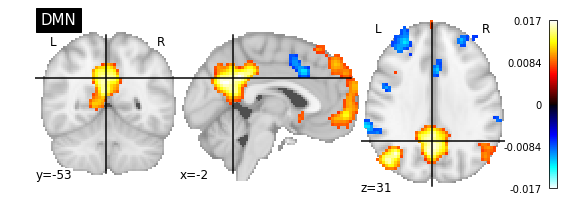

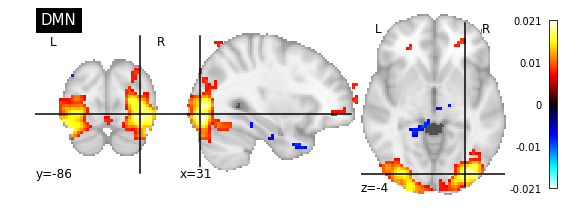

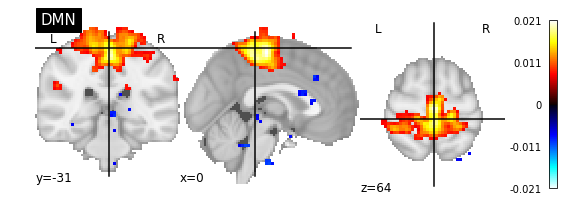

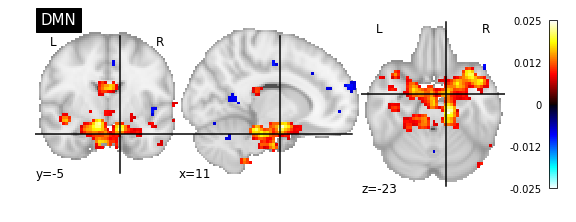

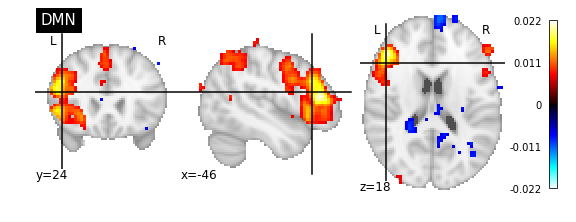

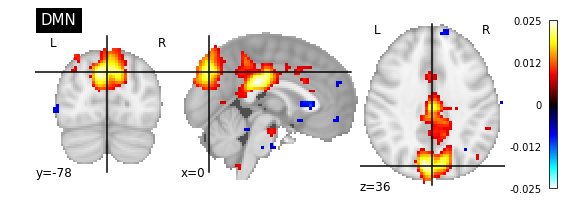

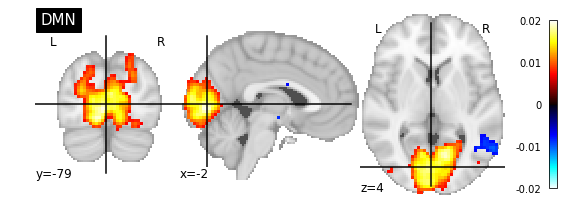

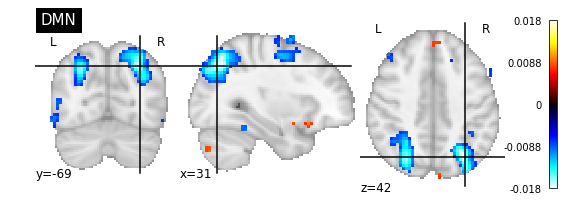

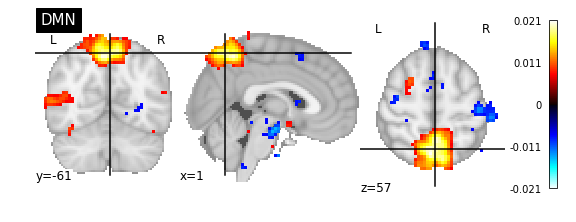

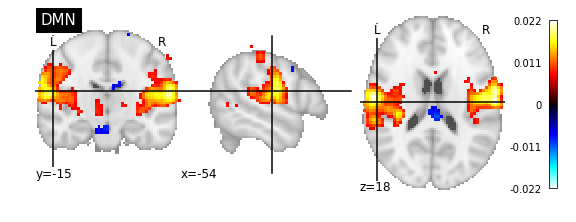

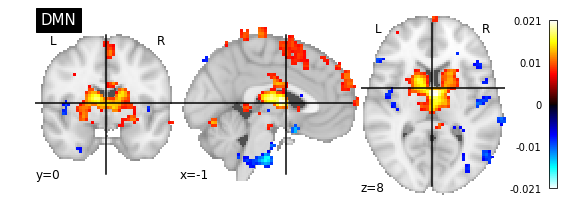

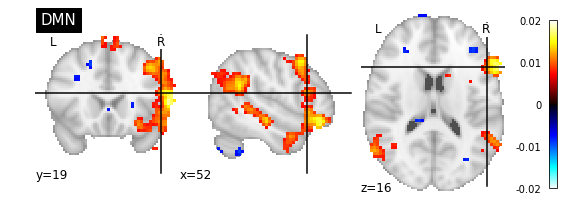

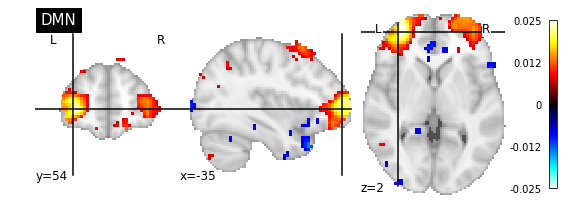

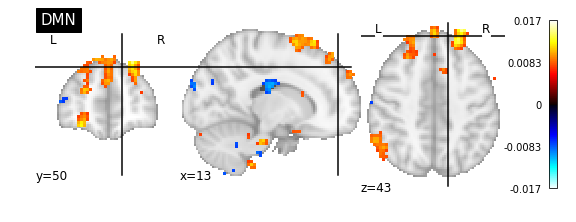

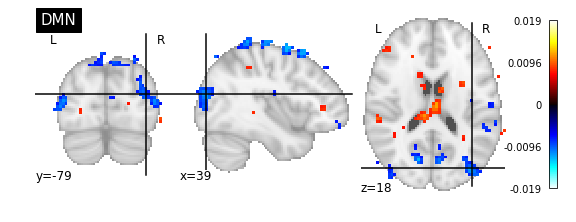

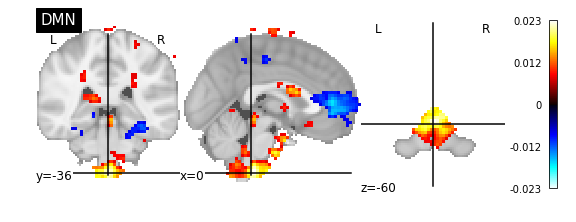

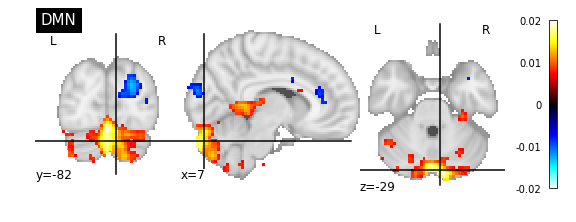

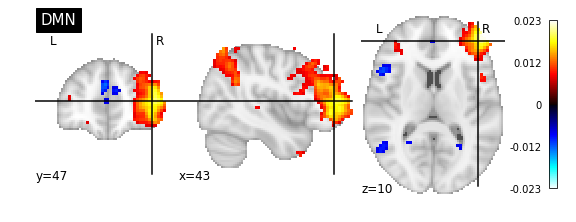

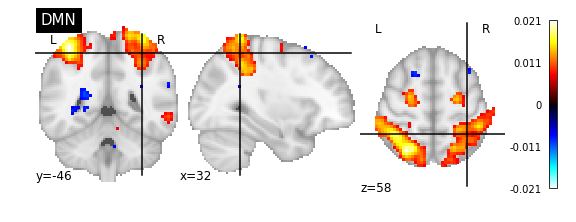

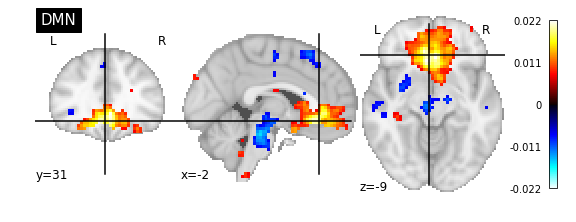

In [31]:
# Retrieve the components
components = canica.components_

# Use CanICA's masker to project the components back into 3D space
components_img = canica.masker_.inverse_transform(components)

# We visualize the generated atlas
from nilearn import plotting, image
for i in range(20):
    plotting.plot_stat_map(image.index_img(components_img, i), title='DMN')
    plotting.show()

# Extracting subject specific timeseries signals from brain parcellations

Computing mask from the data, filtering, extracting data from the in-mask voxels can be processed easily by using nilearn classes such as NiftiMasker, NiftiMapsMasker, NiftiLabelsMasker which can be imported from nilearn.input_data module.

The advantage of using such tools from this module is that we can restrict our analysis to mask specific voxels timeseries data. For instance, class NiftiMasker can be used to compute mask over the data and apply preprocessing steps such as filtering, smoothing, standardizing and detrending on voxels timeseries signals. This type of processing is very much necessary, particularly during resting state fMRI data analysis.
Additional to NiftiMasker, classes NiftiMapsMasker and NiftiLabelsMasker, can be used to extract subject specific timeseries signals on each subject data provided with the atlas maps (3D or 4D) comprising of specific brain regions. NiftiMapsMasker operated on 4D atlas maps, can be used to extract signals from each 4th dimensional map using least squares regression. Whereas, NiftiLabelsMasker operated on 3D maps denoted as labels image, can be used to extract averaged timeseries from group of voxels that correponds to each label in the image.

In [32]:
# Import and initialize `NiftiMapsMasker` object and call `fit_transform` to
# extract timeseries signals from computed atlas.
from nilearn.input_data import NiftiMapsMasker


# The parameters used are maps_img as parcellations, resampling to maps image,
# smoothing of 6mm, detrending, standardizing and filtering (TR in sec). These later
# parameters are applied automatically when extracting timeseries data.
masker = NiftiMapsMasker(components_img,
                         smoothing_fwhm=6, standardize=True, detrend=True,
                         t_r=2.5, low_pass=0.1, high_pass=0.01)

print(masker) # to see the initialization of the parameters.

NiftiMapsMasker(allow_overlap=True, detrend=True, high_pass=0.01,
        low_pass=0.1,
        maps_img=<nibabel.nifti1.Nifti1Image object at 0x1c0f073eb8>,
        mask_img=None, memory=Memory(cachedir=None), memory_level=0,
        resampling_target='data', smoothing_fwhm=6, standardize=True,
        t_r=2.5, verbose=0)


# Extracting time series for each subject


In [33]:
# We loop over the subjects to extract the time series

subjects_timeseries = []
for subject_func in func:
    subjects_timeseries.append(masker.fit_transform(subject_func))

print("Finished extracting timeseries signals for each subject")

Finished extracting timeseries signals for each subject


(176, 20)


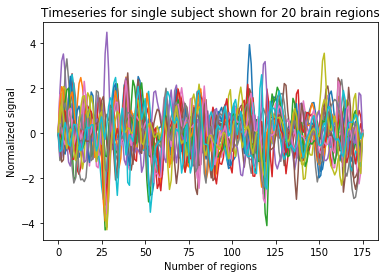

In [34]:
# Visualizing extracted timeseries signals. We import matplotlib.pyplot
import matplotlib.pyplot as plt


# We show them for a single subject
timeseries = subjects_timeseries[0]
print(timeseries.shape) # (number of scans/time points, number of brain regions/parcellations)
plt.plot(timeseries)
plt.title('Timeseries for single subject shown for 20 brain regions')
plt.xlabel('Number of regions')
plt.ylabel('Normalized signal')
plt.show()

# Extracting regions from computed atlas

ICA requires post-preprocessing. Here we use the RegionExtractor that thresholds the maps and extract brain regions.

/Users/Ralf/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/Users/Ralf/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:2778: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/Users/Ralf/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:909: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


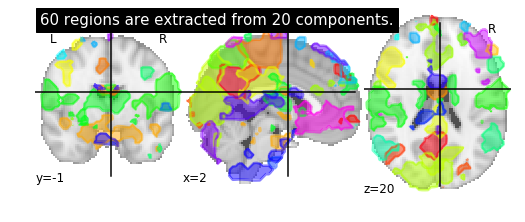

In [35]:
from nilearn.regions import RegionExtractor


extractor = RegionExtractor(components_img, threshold=2.,
                            thresholding_strategy='ratio_n_voxels',
                            extractor='local_regions',
                            standardize=True, min_region_size=1350)

# Just call fit() to process for regions extraction
extractor.fit()

# Extracted regions are stored in regions_img_
regions_extracted_img = extractor.regions_img_

# Total number of regions extracted
n_regions_extracted = regions_extracted_img.shape[-1]

# Visualization of region extraction results
title = ('%d regions are extracted from %d components.'
         % (n_regions_extracted, 20))
plotting.plot_prob_atlas(regions_extracted_img, view_type='filled_contours',
                         title=title, threshold=0.008)

# Scaling up!

For the rest of the tutorial, we will work on 172 subjects from the NYU acquisition site. Fortunately, the Preprocessed Connectome Project provides directly the time series extracted from several atlases.

In [16]:
abide = fetch_abide_pcp(derivatives=['rois_cc200'], SITE_ID=['NYU'], pipeline='cpac')
print(abide.rois_cc200[0].shape)

/Users/Ralf/anaconda3/lib/python3.6/site-packages/numpy/lib/npyio.py:2258: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


(176, 200)


# Connectomes Estimation

Connectivity is typically estimated using correlation between time series. Recent studies has shown that partial correlation could give better results. Different estimators can also be used to apply some regularization on the matrix coefficients. Nilearn's ConnectivityMeasure object (in the nilearn.connectome module) provides three types of connectivity matrix: correlation, partial_correlation, and tangent (a method developped in our laboratory). ConnectivityMeasure can also use any covariance estimator shipped by scikit-learn (ShrunkCovariance, GraphLasso).
In a first time, we estimate the connectivity using default parameters. We check that we have one matrix per subject.

In [17]:
from nilearn.connectome import ConnectivityMeasure


conn_est = ConnectivityMeasure(kind='partial correlation')
conn_matrices = conn_est.fit_transform(abide.rois_cc200)
conn_matrices.shape

(172, 200, 200)

# Plotting connectivity matrix

We visualize the connectivity matrix of the first subject. This code is directly taken from a nilearn example.

Text(0.5,1,'Connectivity matrix of subject 0')

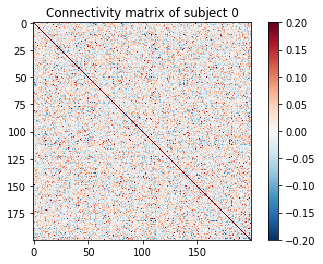

In [18]:
import matplotlib.pyplot as plt

plt.imshow(conn_matrices[0], vmax=.20, vmin=-.20, cmap='RdBu_r')
plt.colorbar()
plt.title('Connectivity matrix of subject 0')

# Extracting useful coefficients

Connecitivity matrices are symmetric. As such, half of the coefficients are redundant. They can even impact the results of some predictors. In order to "extract" these coefficients, we want to use a mask. numpy.tril function can help us with this task. However, using masking is hazardous without a good knowledge of numpy. Fortunately, nilearn provides a function to do this automatically and efficiently: nilearn.connectome.sym_to_vec.

In [19]:
from nilearn.connectome import sym_to_vec


X = sym_to_vec(conn_matrices)
X.shape

/Users/Ralf/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function sym_to_vec is deprecated; Function 'sym_to_vec' has been renamed to 'sym_matrix_to_vec' and will be removed in future releases. 
  warnings.warn(msg, category=DeprecationWarning)


(172, 20100)

# Setting up cross-validation

Getting reliable prediction results require to predict on unseen data. Cross-validation consists in leaving out a part of the dataset (testing set) to validate the model learnt on the remaining of the dataset (training set). Scikit-learn has all the utils necessary to do automatic cross-validation. In the case of ABIDE, we have a very heterogenous dataset and we want the sets to be balanced in term of acquisition sites and condition. We use a stratified cross-validation method for that.

In [20]:
str(abide.phenotypic[['DX_GROUP']])

'[(1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,)\n (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,)\n (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,)\n (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,)\n (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,) (1,)\n (1,) (1,) (1,) (1,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,)\n (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,)\n (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,)\n (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,)\n (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,)\n (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,)\n (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,) (2,)\n (2,) (2,) (2,) (2,)]'

In [21]:
from sklearn.cross_validation import StratifiedShuffleSplit


ids = []
for site_id, dx in abide.phenotypic[['SITE_ID', 'DX_GROUP']]:
    ids.append(str(site_id) + str(dx))
cv = StratifiedShuffleSplit(ids, n_iter=10, test_size=.2)

# Prediction using Support Vector Classifier

Now that we have shown how to estimate a connectome and extract the interesting coefficients, we will see how to use them to diagnose ASD vs healthy individuals.
For that purpose, we use a Support Vector Machine. This is one of the most simple classifiers. We use the default parameters in a first time and look at classification scores.

In [23]:
from sklearn.svm import LinearSVC
from sklearn.cross_validation import cross_val_score
import numpy as np


# DX_GROUP are the labels of the ABIDE dataset. 1=ASD, 2=Healthy
y = abide.phenotypic['DX_GROUP']
predictor = LinearSVC(C=0.01)
np.mean(cross_val_score(predictor, X, y, cv=cv))

0.5742857142857142

# Exploring other methods and parameters

So far, we built a basic prediction procedure without tuning the parameters. Now we use for loops to explore several options. Note that the imbrication of the steps allow us to re-use connectivity matrix computed in the first loop for the different predictors. The same result can be achieved using nilearn's caching capacities.

In [47]:
from sklearn.linear_model import RidgeClassifier


measures = ['correlation', 'partial correlation', 'tangent']
predictors = [
    ('svc_l2', LinearSVC(C=1)),
    ('svc_l1', LinearSVC(C=1, penalty='l1', dual=False)),
    ('ridge_classifier', RidgeClassifier()),
]

for measure in measures:
    conn_est = ConnectivityMeasure(kind=measure)
    conn_matrices = conn_est.fit_transform(abide.rois_cc200)
    X = sym_to_vec(conn_matrices)
    for name, predictor in predictors:
        print(measure, name, np.mean(cross_val_score(predictor, X, y, cv=cv)))

/Users/Ralf/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function sym_to_vec is deprecated; Function 'sym_to_vec' has been renamed to 'sym_matrix_to_vec' and will be removed in future releases. 
  warnings.warn(msg, category=DeprecationWarning)


correlation svc_l2 0.7
correlation svc_l1 0.6228571428571428
correlation ridge_classifier 0.6914285714285715


/Users/Ralf/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function sym_to_vec is deprecated; Function 'sym_to_vec' has been renamed to 'sym_matrix_to_vec' and will be removed in future releases. 
  warnings.warn(msg, category=DeprecationWarning)


partial correlation svc_l2 0.5942857142857143
partial correlation svc_l1 0.5371428571428571
partial correlation ridge_classifier 0.6171428571428571


/Users/Ralf/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function sym_to_vec is deprecated; Function 'sym_to_vec' has been renamed to 'sym_matrix_to_vec' and will be removed in future releases. 
  warnings.warn(msg, category=DeprecationWarning)


tangent svc_l2 0.6314285714285713
tangent svc_l1 0.6314285714285715
tangent ridge_classifier 0.7028571428571428


# Running on full ABIDE!

We try now our prediction on the full dataset.


In [ ]:
# Fetch the full data and update phenotypic data and cross_validation
abide = fetch_abide_pcp(derivatives=['rois_cc200'], pipeline='cpac')
y = abide.phenotypic['DX_GROUP']
ids = []
for site_id, dx in abide.phenotypic[['SITE_ID', 'DX_GROUP']]:
    ids.append(str(site_id) + str(dx))
cv = StratifiedShuffleSplit(ids, n_iter=10, test_size=.2)

for measure in measures:
    conn_est = ConnectivityMeasure(kind=measure)
    conn_matrices = conn_est.fit_transform(abide.rois_cc200)
    X = sym_to_vec(conn_matrices)
    for name, predictor in predictors.items():
        print(measure, name, np.mean(cross_val_score(predictor, X, y, cv=cv)))

/Users/Ralf/anaconda3/lib/python3.6/site-packages/numpy/lib/npyio.py:2258: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


Downloaded 401453 of 401453 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 395590 of 395590 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 397353 of 397353 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 396180 of 396180 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 400860 of 400860 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 397021 of 397021 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 392959 of 392959 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 393408 of 393408 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 397670 of 397670 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 399117 of 399117 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 395891 of 395891 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 395942 of 395942 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 395851 of 395851 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 396717 of 396717 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 396833 of 396833 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 398628 of 398628 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 392947 of 392947 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 395951 of 395951 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 400585 of 400585 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 396170 of 396170 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 400009 of 400009 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 395095 of 395095 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 399097 of 399097 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 395429 of 395429 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 399076 of 399076 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 397616 of 397616 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 400470 of 400470 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 395613 of 395613 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 395991 of 395991 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 396448 of 396448 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 406450 of 406450 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 395655 of 395655 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 393634 of 393634 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 398037 of 398037 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 395528 of 395528 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 396087 of 396087 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 391791 of 391791 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 398230 of 398230 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 396880 of 396880 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 398155 of 398155 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 401288 of 401288 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 398041 of 398041 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 396758 of 396758 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 397112 of 397112 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 402345 of 402345 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 404997 of 404997 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 399726 of 399726 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 396177 of 396177 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 396901 of 396901 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 394352 of 394352 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 418273 of 418273 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 425183 of 425183 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 416707 of 416707 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 420054 of 420054 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 423773 of 423773 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 417352 of 417352 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 424950 of 424950 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 419050 of 419050 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 423085 of 423085 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 417842 of 417842 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 417945 of 417945 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 419160 of 419160 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 419958 of 419958 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 419437 of 419437 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 419053 of 419053 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 419326 of 419326 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 421693 of 421693 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 436728 of 436728 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 420782 of 420782 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 415612 of 415612 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 421592 of 421592 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 419785 of 419785 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 420960 of 420960 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 417312 of 417312 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 417091 of 417091 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 418116 of 418116 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 419045 of 419045 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 424660 of 424660 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 155710 of 155710 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 157614 of 157614 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 156124 of 156124 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 157564 of 157564 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 156434 of 156434 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 157025 of 157025 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 157282 of 157282 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 156835 of 156835 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 155920 of 155920 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 157213 of 157213 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 156966 of 156966 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 156302 of 156302 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 155845 of 155845 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 156877 of 156877 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 156946 of 156946 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 156038 of 156038 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 158513 of 158513 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 158601 of 158601 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 156359 of 156359 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 158692 of 158692 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 157124 of 157124 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 157280 of 157280 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 157765 of 157765 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 157923 of 157923 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 155891 of 155891 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 357132 of 357132 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 354179 of 354179 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 349333 of 349333 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 359212 of 359212 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 353603 of 353603 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 356803 of 356803 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 355329 of 355329 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 354568 of 354568 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 355134 of 355134 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 358174 of 358174 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 341039 of 341039 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 356390 of 356390 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 356641 of 356641 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 355082 of 355082 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 355157 of 355157 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 358730 of 358730 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 360301 of 360301 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 356231 of 356231 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 354286 of 354286 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 353996 of 353996 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 359422 of 359422 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 358046 of 358046 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 351290 of 351290 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 359183 of 359183 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 357957 of 357957 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 356547 of 356547 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 355721 of 355721 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 298152 of 298152 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 295171 of 295171 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 297119 of 297119 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 295441 of 295441 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 295512 of 295512 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 298131 of 298131 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 296006 of 296006 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 296668 of 296668 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 297352 of 297352 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 296849 of 296849 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 299635 of 299635 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 292130 of 292130 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 295740 of 295740 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 297796 of 297796 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 298412 of 298412 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 297048 of 297048 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 296747 of 296747 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 296931 of 296931 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 297458 of 297458 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 294269 of 294269 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 293910 of 293910 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 295339 of 295339 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 295604 of 295604 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 301805 of 301805 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 295796 of 295796 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 295029 of 295029 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 302089 of 302089 bytes (100.0%,    0.0s remaining) ...done. (0 seconds, 0 min)


Downloaded 295932 of 295932 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)


Downloaded 296254 of 296254 bytes (100.0%,    0.0s remaining) ...done. (1 seconds, 0 min)
